# <center> CREDIT CARD APPROVAL PREDICTION </center>

In [1]:
# Importing necessary libraries
import warnings
warnings.filterwarnings('ignore')  # Ignore warnings to improve code readability

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE  # Importing SMOTE for oversampling
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

In [2]:
#importing the data using pandas
dataset = pd.read_csv("application_record.csv")
records_file = pd.read_csv("credit_record.csv")

In [3]:
dataset.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [4]:
dataset.shape

(438557, 18)

In [5]:
records_file.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [6]:
records_file.shape

(1048575, 3)

In [7]:
# Setting the facecolor of matplotlib figures to white
plt.rcParams['figure.facecolor'] = 'white'

In [8]:
# Find all users' account open month
begin_month = pd.DataFrame(records_file.groupby(["ID"])["MONTHS_BALANCE"].agg(min))
begin_month = begin_month.rename(columns={'MONTHS_BALANCE': 'begin_month1'})

# Merge data_set and begin_month using the merge method
new_data = dataset.merge(begin_month, how="left", on="ID")


In [9]:
# Create a new column 'dep_value' in the 'records_file' DataFrame based on certain conditions
records_file['dep_value'] = np.where((records_file['STATUS'] == '2') | (records_file['STATUS'] == '3') |
                               (records_file['STATUS'] == '4') | (records_file['STATUS'] == '5'), 'Yes', None)

In [10]:
# Perform operations to create a 'target' variable based on the 'dep_value' column

# Group 'records_file' by 'ID' and count occurrences, storing the result in 'cpunt' DataFrame
cpunt = records_file.groupby('ID').count()

# Set 'dep_value' to 'Yes' if the count of occurrences is greater than 0, otherwise set it to 'No'
cpunt['dep_value'][cpunt['dep_value'] > 0] = 'Yes'
cpunt['dep_value'][cpunt['dep_value'] == 0] = 'No'

# Extract the 'dep_value' column and create a new DataFrame 'cpunt' with only this column
cpunt = cpunt[['dep_value']]

# Merge 'new_data' with 'cpunt' based on the common 'ID' column, using an inner join
new_data = pd.merge(new_data, cpunt, how='inner', on='ID')

# Create a new 'target' column in 'new_data' and set it equal to 'dep_value'
new_data['target'] = new_data['dep_value']

# Map 'Yes' to 1 and 'No' to 0 in the 'target' column
new_data.loc[new_data['target'] == 'Yes', 'target'] = 1
new_data.loc[new_data['target'] == 'No', 'target'] = 0

In [11]:
print(cpunt['dep_value'].value_counts())
print(cpunt['dep_value'].value_counts(normalize=True))

dep_value
No     45318
Yes      667
Name: count, dtype: int64
dep_value
No     0.985495
Yes    0.014505
Name: proportion, dtype: float64


In [12]:
dataset.DAYS_BIRTH.describe()

count    438557.000000
mean     -15997.904649
std        4185.030007
min      -25201.000000
25%      -19483.000000
50%      -15630.000000
75%      -12514.000000
max       -7489.000000
Name: DAYS_BIRTH, dtype: float64

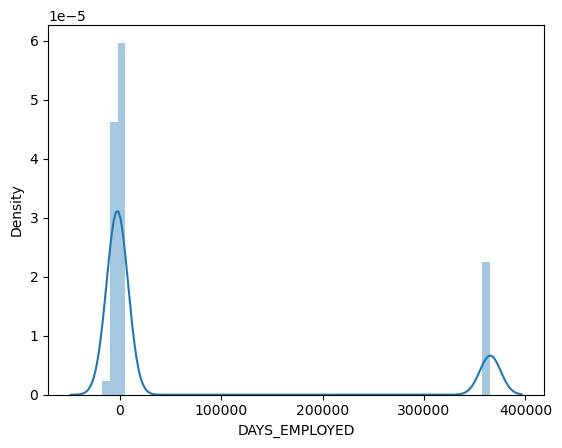

In [13]:
sns.distplot(dataset.DAYS_EMPLOYED)
plt.show()

In [14]:
dataset.ID.nunique()

438510

In [15]:
# Rename columns in the 'new_data' DataFrame for improved readability
new_data.rename(columns={'CODE_GENDER':'Gender','FLAG_OWN_CAR':'Car','FLAG_OWN_REALTY':'Reality',
                         'CNT_CHILDREN':'ChldNo','AMT_INCOME_TOTAL':'inc',
                         'NAME_EDUCATION_TYPE':'edutp','NAME_FAMILY_STATUS':'famtp',
                        'NAME_HOUSING_TYPE':'houtp','FLAG_EMAIL':'email',
                         'NAME_INCOME_TYPE':'inctp','FLAG_WORK_PHONE':'wkphone',
                         'FLAG_PHONE':'phone','CNT_FAM_MEMBERS':'famsize',
                        'OCCUPATION_TYPE':'occyp'
                        },inplace=True)

In [25]:
new_data.head()

,ID,Gender,Car,Reality,ChldNo,inc,inctp,edutp,famtp,houtp,...,DAYS_EMPLOYED,FLAG_MOBIL,wkphone,phone,email,occyp,famsize,begin_month1,dep_value,target
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,-1134,1,0,0,0,Security staff,2.0,-29.0,No,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3051,1,0,1,1,Sales staff,1.0,-4.0,No,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3051,1,0,1,1,Sales staff,1.0,-26.0,No,0
5,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3051,1,0,1,1,Sales staff,1.0,-26.0,No,0
6,5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3051,1,0,1,1,Sales staff,1.0,-38.0,No,0


In [26]:
new_data.shape

(25134, 21)

In [29]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25134 entries, 2 to 36456
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             25134 non-null  int64  
 1   Gender         25134 non-null  object 
 2   Car            25134 non-null  object 
 3   Reality        25134 non-null  object 
 4   ChldNo         25134 non-null  int64  
 5   inc            25134 non-null  float64
 6   inctp          25134 non-null  object 
 7   edutp          25134 non-null  object 
 8   famtp          25134 non-null  object 
 9   houtp          25134 non-null  object 
 10  DAYS_BIRTH     25134 non-null  int64  
 11  DAYS_EMPLOYED  25134 non-null  int64  
 12  FLAG_MOBIL     25134 non-null  int64  
 13  wkphone        25134 non-null  int64  
 14  phone          25134 non-null  int64  
 15  email          25134 non-null  int64  
 16  occyp          25134 non-null  object 
 17  famsize        25134 non-null  float64
 18  begin_month

In [16]:
# Drop rows with any missing values in the 'new_data' DataFrame
new_data.dropna()
# Replace 'NULL' values with NaN and then drop rows with any remaining missing values
new_data = new_data.mask(new_data == 'NULL').dropna()

In [17]:
new_data.isna().sum()

ID               0
Gender           0
Car              0
Reality          0
ChldNo           0
inc              0
inctp            0
edutp            0
famtp            0
houtp            0
DAYS_BIRTH       0
DAYS_EMPLOYED    0
FLAG_MOBIL       0
wkphone          0
phone            0
email            0
occyp            0
famsize          0
begin_month1     0
dep_value        0
target           0
dtype: int64

In [18]:
# Create a DataFrame 'ivtable' with a column 'variable' containing the names of columns in 'new_data'
ivtable = pd.DataFrame(new_data.columns, columns=['variable'])

# Add a column 'IV' to 'ivtable' and initialize it with None
ivtable['IV'] = None

# List of column names to be excluded from the information value (IV) calculation
namelist = ['FLAG_MOBIL', 'begin_month', 'dep_value', 'target', 'ID']

# Iterate through the 'namelist' and remove corresponding rows from 'ivtable'
for i in namelist:
    ivtable.drop(ivtable[ivtable['variable'] == i].index, inplace=True)

In [19]:
# Calculate information value
# Function to calculate Information Value (IV) for a given feature in a dataframe
def calc_iv(df, feature, target, pr=False):
    lst = []
    df[feature] = df[feature].fillna("NULL")

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good (think: Fraud == 0)
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Bad (think: Fraud == 1)

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])
    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])

    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print('IV = ', data['IV'].sum())

    iv = data['IV'].sum()
    print('This variable\'s IV is:',iv)
    print(df[feature].value_counts())
    return iv, data

In [20]:
# Function to convert a categorical feature into dummy variables in a dataframe
def convert_dummy(df, feature, rank=0):
    dummies = pd.get_dummies(df[feature], prefix=feature)
    mode_value = df[feature].value_counts().index[rank]
    mode_column = f"{feature}_{mode_value}"

    # Drop the column corresponding to the mode
    dummies.drop([mode_column], axis=1, inplace=True)

    # Drop the original feature and join the dummy columns
    df.drop([feature], axis=1, inplace=True)
    df = pd.concat([df, dummies], axis=1)

    return df

In [21]:
# Function to create a categorical variable based on binning a numerical column in a dataframe
def get_category(df, col, binsnum, labels, qcut = False):
    # Perform binning based on quantiles (qcut) or equal-length intervals
    if qcut:
        localdf = pd.qcut(df[col], q = binsnum, labels = labels) # quantile cut
    else:
        localdf = pd.cut(df[col], bins = binsnum, labels = labels) # equal-length cut

    localdf = pd.DataFrame(localdf)
    name = 'gp' + '_' + col
    localdf[name] = localdf[col]
    df = df.join(localdf[name])
    df[name] = df[name].astype(object)
    return df

In [22]:
# Function to plot a confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    # Normalize the confusion matrix if specified
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Print the confusion matrix
    print(cm)

    # Plot the confusion matrix
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Set tick marks and labels for both axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # Display the values in each cell of the matrix
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    # Set labels and adjust layout for better visualization
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Is there any correlation between the number of children and applicant has and their income?

Correlation Matrix:
          ChldNo       inc
ChldNo  1.000000 -0.015081
inc    -0.015081  1.000000


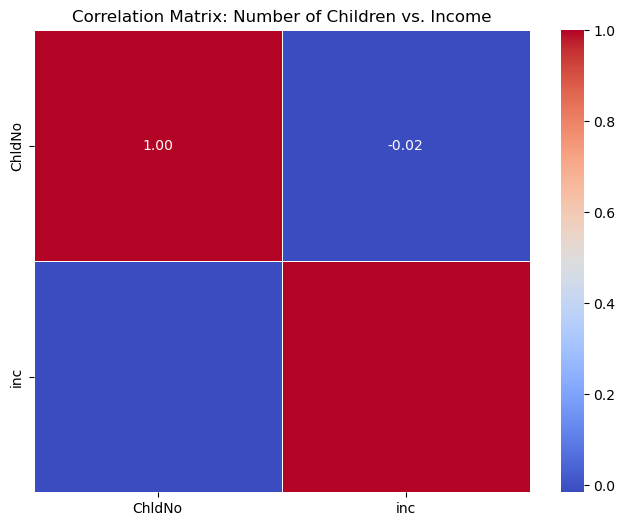

In [23]:
# Combine 'ChldNo' and 'inc' columns for correlation analysis
correlation_data = new_data[['ChldNo', 'inc']]

# Calculate the correlation matrix
correlation_matrix = correlation_data.corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix: Number of Children vs. Income')
plt.show()

In [24]:
# Calculate the correlation matrix
correlation_matrix = new_data.corr()

# Set the style to white with a dark background
sns.set(style="white", font_scale=1.2)

# Create a diverging colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap=cmap, annot=True, fmt=".2f", linewidths=.5)
plt.title('Correlation Map with Diverging Colormap')
plt.show()

ValueError: could not convert string to float: 'M'

Are there any patterns in the employment status of credit card applicants?

In [ ]:
# Count the occurrences of each employment status
employment_counts = new_data['inctp'].value_counts()

# Display the counts
print("Employment Status Distribution:")
print(employment_counts)

# Visualize the distribution using a bar plot
plt.figure(figsize=(10, 6))
sns.countplot(x='inctp', data=new_data, palette='viridis')
plt.title('Employment Status Distribution of Credit Card Applicants')
plt.xlabel('Employment Status')
plt.ylabel('Count')
plt.show()

In [ ]:
# Replace categorical values in the 'Gender' column with numerical values
new_data['Gender'] = new_data['Gender'].replace(['F', 'M'], [0, 1])

# Print the counts of unique values in the 'Gender' column
print(new_data['Gender'].value_counts())

# Calculate Information Value (IV) for the 'Gender' variable and update the IV table
iv, data = calc_iv(new_data, 'Gender', 'target')
ivtable.loc[ivtable['variable'] == 'Gender', 'IV'] = iv

# Display the first few rows of the data DataFrame
data.head()

In [ ]:
# Mapping 'N' to 0 and 'Y' to 1 in 'Car' column
new_data['Car'] = new_data['Car'].map({'N': 0, 'Y': 1})

# Print the value counts after mapping
print(new_data['Car'].value_counts())

# Calculate IV for 'Car' and update the ivtable
iv, data = calc_iv(new_data, 'Car', 'target')
ivtable.loc[ivtable['variable'] == 'Car', 'IV'] = iv

# Display the first few rows of the calculated data
data.head()

In [ ]:
# Mapping 'N' to 0 and 'Y' to 1 in 'Reality' column
new_data['Reality'] = new_data['Reality'].map({'N': 0, 'Y': 1})

# Print the value counts after mapping
print(new_data['Reality'].value_counts())

# Calculate IV for 'Reality' and update the ivtable
iv, data = calc_iv(new_data, 'Reality', 'target')
ivtable.loc[ivtable['variable'] == 'Reality', 'IV'] = iv

# Display the first few rows of the calculated data
data.head()

In [ ]:
# Convert 'phone' column to string
new_data['phone'] = new_data['phone'].astype(str)

# Print the value counts after converting to string
print(new_data['phone'].value_counts(normalize=True, sort=False))

# Drop rows where 'phone' is 'nan'
new_data.drop(new_data[new_data['phone'] == 'nan'].index, inplace=True)

# Calculate IV for 'phone' and update the ivtable
iv, data = calc_iv(new_data, 'phone', 'target')
ivtable.loc[ivtable['variable'] == 'phone', 'IV'] = iv

# Display the first few rows of the calculated data
data.head()

In [ ]:
# Print the value counts for 'email'
print(new_data['email'].value_counts(normalize=True, sort=False))

# Convert 'email' column to string
new_data['email'] = new_data['email'].astype(str)

# Calculate IV for 'email' and update the ivtable
iv, data = calc_iv(new_data, 'email', 'target')
ivtable.loc[ivtable['variable'] == 'email', 'IV'] = iv

# Display the first few rows of the calculated data
data.head()


In [ ]:
# Convert 'wkphone' column to string
new_data['wkphone'] = new_data['wkphone'].astype(str)

# Calculate IV for 'wkphone' and update the ivtable
iv, data = calc_iv(new_data, 'wkphone', 'target')

# Drop rows where 'wkphone' is 'nan'
new_data.drop(new_data[new_data['wkphone'] == 'nan'].index, inplace=True)

# Update IV in ivtable
ivtable.loc[ivtable['variable'] == 'wkphone', 'IV'] = iv

# Display the first few rows of the calculated data
data.head()

In [ ]:
# Update 'ChldNo' values based on the condition
new_data['ChldNo'] = np.where(new_data['ChldNo'] >= 2, '2More', new_data['ChldNo'])

# Print the value counts for 'ChldNo'
print(new_data['ChldNo'].value_counts(sort=False))

In [ ]:
# Calculate IV for 'ChldNo' and update the ivtable
iv, data = calc_iv(new_data, 'ChldNo', 'target')
ivtable.loc[ivtable['variable'] == 'ChldNo', 'IV'] = iv

# Display the first few rows of the calculated data
data.head()

In [ ]:
new_data = convert_dummy(new_data, 'ChldNo')

In [ ]:
# Convert 'inc' column to object type
new_data['inc'] = new_data['inc'].astype(object)

# Scale 'inc' values by dividing by 10000
new_data['inc'] /= 10000

# Print the value counts for 'inc' in bins
print(new_data['inc'].value_counts(bins=10, sort=False))

# Plot a histogram for 'inc'
new_data['inc'].plot(kind='hist', bins=50, density=True)

In [ ]:
# Calculate 'Age' based on 'DAYS_BIRTH' and negate the result
new_data['Age'] = -(new_data['DAYS_BIRTH'] // 365)

# Print the value counts for 'Age' in bins
print(new_data['Age'].value_counts(bins=10, normalize=True, sort=False))

# Plot a histogram for 'Age'
new_data['Age'].plot(kind='hist', bins=20, density=True)

How does age relate to the likelihood of credit card approval?

In [ ]:
# Visualize the relationship between age and credit card approval
plt.figure(figsize=(12, 8))
sns.boxplot(x='target', y='Age', data=new_data, palette='Set2')
plt.title('Age Distribution by Credit Card Approval')
plt.xlabel('Credit Card Approval (0: No, 1: Yes)')
plt.ylabel('Age')
plt.show()

Is there a significant difference in income between car owners and non-car owners?

In [ ]:
from scipy.stats import ttest_ind

# Convert 'inc' column to numeric data type
new_data['inc'] = pd.to_numeric(new_data['inc'], errors='coerce')

# Separate data for car owners and non-car owners
car_owners_income = new_data.loc[new_data['Car'] == 1, 'inc']
non_car_owners_income = new_data.loc[new_data['Car'] == 0, 'inc']

# Perform an independent t-test
t_statistic, p_value = ttest_ind(car_owners_income, non_car_owners_income, equal_var=False)

# Display the results
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Set significance level
alpha = 0.05

# Check for significance
if p_value < alpha:
    print("There is a significant difference in income between car owners and non-car owners.")
else:
    print("There is no significant difference in income between car owners and non-car owners.")


Do people with different education levels have varying rates of credit card approval?

In [ ]:
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(new_data['edutp'], new_data['target'])

# Perform a chi-squared test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Display the results
print(f"Chi-squared statistic: {chi2_stat}")
print(f"P-value: {p_value}")

# Set significance level
alpha = 0.05

# Check for significance
if p_value < alpha:
    print("There is a significant relationship between education level and credit card approval.")
else:
    print("There is no significant relationship between education level and credit card approval.")


In [ ]:
# Create a new category column 'gp_Age' using get_category
new_data = get_category(new_data, 'Age', 5, ["lowest", "low", "medium", "high", "highest"])

# Calculate IV for 'gp_Age' and update the ivtable
iv, data = calc_iv(new_data, 'gp_Age', 'target')
ivtable.loc[ivtable['variable'] == 'DAYS_BIRTH', 'IV'] = iv

# Display the first few rows of the calculated data
data.head()

In [ ]:
new_data = convert_dummy(new_data, 'gp_Age')

In [ ]:
# Calculate 'worktm' based on 'DAYS_EMPLOYED' and replace negative values with NaN
new_data['worktm'] = -(new_data['DAYS_EMPLOYED']) // 365
new_data.loc[new_data['worktm'] < 0, 'worktm'] = np.nan

# Replace NaN values in 'worktm' with mean
new_data['worktm'].fillna(new_data['worktm'].mean(), inplace=True)

# Plot a histogram for 'worktm'
new_data['worktm'].plot(kind='hist', bins=20, density=True)

In [ ]:
# Create a new category column 'gp_worktm' using get_category
new_data = get_category(new_data, 'worktm', 5, ["lowest", "low", "medium", "high", "highest"])

# Calculate IV for 'gp_worktm' and update the ivtable
iv, data = calc_iv(new_data, 'gp_worktm', 'target')
ivtable.loc[ivtable['variable'] == 'DAYS_EMPLOYED', 'IV'] = iv

# Display the first few rows of the calculated data
data.head()

In [ ]:
new_data = convert_dummy(new_data, 'gp_worktm')

In [ ]:
# Print the value counts for 'famsize'
print(new_data['famsize'].value_counts(sort=False))

In [ ]:
# Convert 'famsize' to int
new_data['famsize'] = new_data['famsize'].astype(int)

# Create a new category column 'famsizegp'
new_data['famsizegp'] = new_data['famsize'].astype(object)
new_data.loc[new_data['famsizegp'] >= 3, 'famsizegp'] = '3more'

# Calculate IV for 'famsizegp' and update the ivtable
iv, data = calc_iv(new_data, 'famsizegp', 'target')
ivtable.loc[ivtable['variable'] == 'famsize', 'IV'] = iv

# Display the first few rows of the calculated data
data.head()

In [ ]:
new_data = convert_dummy(new_data, 'famsizegp')

In [ ]:
# Print the value counts for 'inctp'
print(new_data['inctp'].value_counts(sort=False))

# Print the normalized value counts for 'inctp'
print(new_data['inctp'].value_counts(normalize=True, sort=False))

# Replace values in 'inctp'
new_data['inctp'].replace({'Pensioner': 'State servant', 'Student': 'State servant'}, inplace=True)

# Calculate IV for 'inctp' and update the ivtable
iv, data = calc_iv(new_data, 'inctp', 'target')
ivtable.loc[ivtable['variable'] == 'inctp', 'IV'] = iv

# Display the first few rows of the calculated data
data.head()

In [ ]:
new_data = convert_dummy(new_data, 'inctp')

In [ ]:
# Define mappings for 'occyp'
occyp_mapping = {
    'Cleaning staff': 'Laborwk',
    'Cooking staff': 'Laborwk',
    'Drivers': 'Laborwk',
    'Laborers': 'Laborwk',
    'Low-skill Laborers': 'Laborwk',
    'Security staff': 'Laborwk',
    'Waiters/barmen staff': 'Laborwk',
    'Accountants': 'officewk',
    'Core staff': 'officewk',
    'HR staff': 'officewk',
    'Medicine staff': 'officewk',
    'Private service staff': 'officewk',
    'Realty agents': 'officewk',
    'Sales staff': 'officewk',
    'Secretaries': 'officewk',
    'Managers': 'hightecwk',
    'High skill tech staff': 'hightecwk',
    'IT staff': 'hightecwk'
}

# Map values in 'occyp' based on the defined mapping
new_data['occyp'] = new_data['occyp'].map(occyp_mapping)

# Print the value counts for 'occyp'
print(new_data['occyp'].value_counts())

# Calculate IV for 'occyp' and update the ivtable
iv, data = calc_iv(new_data, 'occyp', 'target')
ivtable.loc[ivtable['variable'] == 'occyp', 'IV'] = iv

# Display the first few rows of the calculated data
data.head()


In [ ]:
new_data = convert_dummy(new_data, 'occyp')

In [ ]:
# Calculate IV for 'houtp' and update the ivtable
iv, data = calc_iv(new_data, 'houtp', 'target')
ivtable.loc[ivtable['variable'] == 'houtp', 'IV'] = iv

# Display the first few rows of the calculated data
data.head()

In [ ]:
new_data = convert_dummy(new_data, 'houtp')

In [ ]:
# Replace values in 'edutp'
new_data['edutp'].replace({'Academic degree': 'Higher education'}, inplace=True)

# Calculate IV for 'edutp' and update the ivtable
iv, data = calc_iv(new_data, 'edutp', 'target')
ivtable.loc[ivtable['variable'] == 'edutp', 'IV'] = iv

# Display the first few rows of the calculated data
data.head()

In [ ]:
new_data = convert_dummy(new_data, 'edutp')

In [ ]:
# Print the normalized value counts for 'famtp'
print(new_data['famtp'].value_counts(normalize=True, sort=False))

In [ ]:
# Calculate IV for 'famtp' and update the ivtable
iv, data = calc_iv(new_data, 'famtp', 'target')
ivtable.loc[ivtable['variable'] == 'famtp', 'IV'] = iv

# Display the first few rows of the calculated data
data.head()

In [ ]:
new_data = convert_dummy(new_data, 'famtp')

In [ ]:
# Sort ivtable by 'IV' in descending order
ivtable = ivtable.sort_values(by='IV', ascending=False)

# Rename specific variables in the 'variable' column
rename_mapping = {'DAYS_BIRTH': 'agegp', 'DAYS_EMPLOYED': 'worktmgp', 'inc': 'incgp'}
ivtable['variable'] = ivtable['variable'].replace(rename_mapping)

# Display the updated ivtable
ivtable

In [ ]:
# Print the columns of the DataFrame
print(new_data.columns)

In [ ]:
# Define the target variable Y and features X
target_variable = 'target'
feature_columns = ['ID', 'Gender', 'Reality', 'ChldNo_1', 'ChldNo_2More', 'wkphone',
                    'gp_Age_high', 'gp_Age_highest', 'gp_Age_low', 'gp_Age_lowest',
                    'gp_worktm_high', 'gp_worktm_highest', 'gp_worktm_low', 'gp_worktm_medium',
                    'occyp_hightecwk', 'occyp_officewk', 'famsizegp_1', 'famsizegp_3more',
                    'houtp_Co-op apartment', 'houtp_Municipal apartment', 'houtp_Office apartment',
                    'houtp_Rented apartment', 'houtp_With parents', 'edutp_Higher education',
                    'edutp_Incomplete higher', 'edutp_Lower secondary', 'famtp_Civil marriage',
                    'famtp_Separated', 'famtp_Single / not married', 'famtp_Widow']

Y = new_data[target_variable]
X = new_data[feature_columns]

In [ ]:
from imblearn.over_sampling import SMOTE

# Convert the target variable Y to integer
Y = Y.astype('int')

# Perform SMOTE resampling
smote = SMOTE()
X_balance, Y_balance = smote.fit_resample(X, Y)

# Convert the resampled features to a DataFrame with original column names
X_balance = pd.DataFrame(X_balance, columns=X.columns)

In [ ]:
from sklearn.model_selection import train_test_split

# Specify the test size and random state
test_size = 0.3
random_state = 10086

# Perform the train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(X_balance, Y_balance,
                                                    stratify=Y_balance,
                                                    test_size=test_size,
                                                    random_state=random_state)

In [ ]:
X_train.head()

In [ ]:
# Extract the 'ID' column from X_train and X_test
X_train_ID = X_train['ID'].copy()
X_test_ID = X_test['ID'].copy()

In [ ]:
# Extract the 'ID' column from X_test with copy
X_test_ID = X_test['ID'].copy()

In [ ]:
X_test.head()

In [ ]:
from sklearn.linear_model import LogisticRegression

# Create and train the Logistic Regression model
model = LogisticRegression(C=0.8, random_state=0, solver='lbfgs')
model.fit(X_train, y_train)

# Make predictions on the test set
y_predict = model.predict(X_test)

# Calculate and print the accuracy score
accuracy = accuracy_score(y_test, y_predict)
print('Accuracy Score is {:.5}'.format(accuracy))

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_predict)
print(pd.DataFrame(conf_matrix))

# Visualize the confusion matrix
sns.set_style('white')
class_names = ['0', '1']
plot_confusion_matrix(conf_matrix, classes=class_names, title='Confusion Matrix: Logistic Regression')

In [ ]:
# Check the lengths of y_predict, y_test, and X_test_ID
length_y_predict = len(y_predict)
length_y_test = len(y_test)
length_X_test_ID = len(X_test_ID)

print(f"Length of y_predict: {length_y_predict}")
print(f"Length of y_test: {length_y_test}")
print(f"Length of X_test_ID: {length_X_test_ID}")

In [ ]:
# Create final_prediction_caparison DataFrame
final_prediction_caparison = pd.DataFrame({'ID': X_test_ID, 'y_test': y_test, 'y_predict': y_predict})

# Display the DataFrame
final_prediction_caparison

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Create and train the Decision Tree model
model = DecisionTreeClassifier(max_depth=12, min_samples_split=8, random_state=1024)
model.fit(X_train, y_train)

# Make predictions on the test set
y_predict = model.predict(X_test)

# Calculate and print the accuracy score
accuracy = accuracy_score(y_test, y_predict)
print('Accuracy Score is {:.5}'.format(accuracy))

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_predict)
print(pd.DataFrame(conf_matrix))

# Visualize the confusion matrix
sns.set_style('white')
class_names = ['0', '1']
plot_confusion_matrix(conf_matrix, classes=class_names, title='Confusion Matrix: Decision Tree')

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create and train the Random Forest model
model = RandomForestClassifier(n_estimators=250, max_depth=12, min_samples_leaf=16)
model.fit(X_train, y_train)

# Make predictions on the test set
y_predict = model.predict(X_test)

# Calculate and print the accuracy score
accuracy = accuracy_score(y_test, y_predict)
print('Accuracy Score is {:.5}'.format(accuracy))

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_predict)
print(pd.DataFrame(conf_matrix))

# Visualize the confusion matrix
sns.set_style('white')
class_names = ['0', '1']
plot_confusion_matrix(conf_matrix, classes=class_names, title='Confusion Matrix: Random Forests')

In [ ]:
from sklearn.svm import SVC

# Create and train the Support Vector Machine model
svm_model = SVC(C=1, kernel='rbf', gamma='scale', random_state=42)
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_predict_svm = svm_model.predict(X_test)

# Calculate and print the accuracy score
accuracy_svm = accuracy_score(y_test, y_predict_svm)
print('Accuracy Score for SVM is {:.5}'.format(accuracy_svm))

# Print the confusion matrix for SVM
conf_matrix_svm = confusion_matrix(y_test, y_predict_svm)
print(conf_matrix_svm)

# Visualize the confusion matrix for SVM
sns.set_style('white')
class_names_svm = ['0', '1']
plot_confusion_matrix(conf_matrix_svm, classes=class_names_svm, title='Confusion Matrix: SVM')
